In [5]:
pip install -U albumentations

Note: you may need to restart the kernel to use updated packages.


In [6]:
%cd  /Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/src

/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/src


# Adversarial Image Generation with PyTorch and OpenCV

In [88]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from glob import glob
from torchvision.transforms.functional import to_pil_image, to_tensor
from torch.nn import functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from model import build_model  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gaussian_blur(image, kernel_size=5, sigma=2):
    """
    Applies Gaussian blurring using OpenCV.
    """
    image_np = image.squeeze(0).permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)  
    blurred_np = cv2.GaussianBlur(image_np, (kernel_size, kernel_size), sigmaX=sigma)
    blurred_tensor = to_tensor(blurred_np).unsqueeze(0)
    return blurred_tensor

def pgd_attack(model, image, epsilon, alpha, num_steps, y_true, targeted=False, random_start=True):
    model.eval()
    perturbed_image = image.clone().detach()
    if random_start:
        perturbed_image += (2 * epsilon * torch.rand_like(image) - epsilon)
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
    perturbed_image.requires_grad = True
    for _ in range(num_steps):
        outputs = model(perturbed_image)
        model.zero_grad()
        loss = F.cross_entropy(outputs, y_true)
        if targeted:
            loss = -loss
        loss.backward()
        with torch.no_grad():
            perturbed_image.data += alpha * perturbed_image.grad.sign()
            perturbation = torch.clamp(perturbed_image - image, -epsilon, epsilon)
            perturbed_image.data = torch.clamp(image + perturbation, 0, 1)
        perturbed_image.grad.zero_()
    return perturbed_image.detach()

def fgsm_attack(model, x, y, epsilon, iterations=1):
    model.eval()
    x_adv = x.clone().detach().requires_grad_(True)
    output = model(x_adv)
    loss = F.cross_entropy(output, y)
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        x_adv += epsilon * x_adv.grad.sign()
        x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv.detach()

def createAdversarialImages():
    sign_names_df = pd.read_csv('../input/signnames.csv')
    gt_df = pd.read_csv('../input/GTSRB_Final_Test_GT/GT-final_test.csv', delimiter=';')
    gt_df = gt_df.set_index('Filename', drop=True)
    model = build_model(pretrained=False, fine_tune=False, num_classes=43).to(device)
    model.eval()
    model.load_state_dict(torch.load('../outputs/model.pth', map_location=device)['model_state_dict'])
    transform = A.Compose([ToTensorV2()])
    base_dir = '../input/GTSRB_Final_Test_Images/GTSRB/Final_Test'
    blur_dir = os.path.join(base_dir, 'gaussian_blur')
    pgd_dir = os.path.join(base_dir, 'pgd_attack')
    fgsm_dir = os.path.join(base_dir, 'fgsm_attack')
    os.makedirs(blur_dir, exist_ok=True)
    os.makedirs(pgd_dir, exist_ok=True)
    os.makedirs(fgsm_dir, exist_ok=True)
    all_images = glob(os.path.join(base_dir, 'Images', '*.ppm'))
    for image_path in all_images:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0
        image_tensor = transform(image=image)['image'].unsqueeze(0).to(device)
        blurred_tensor = gaussian_blur(image_tensor)
        blurred_image = to_pil_image(blurred_tensor.squeeze(0))
        blurred_image.save(os.path.join(blur_dir, os.path.basename(image_path)), format='PPM')
        y_true = torch.tensor([gt_df.loc[os.path.basename(image_path), 'ClassId']]).to(device)
        pgd_tensor = pgd_attack(model, image_tensor, 0.1, 0.04, 10, y_true)
        pgd_image = to_pil_image(pgd_tensor.squeeze(0))
        pgd_image.save(os.path.join(pgd_dir, os.path.basename(image_path)), format='PPM')
        fgsm_tensor = fgsm_attack(model, image_tensor, y_true, 0.1, 1)
        fgsm_image = to_pil_image(fgsm_tensor.squeeze(0))
        fgsm_image.save(os.path.join(fgsm_dir, os.path.basename(image_path)), format='PPM')

createAdversarialImages()


[INFO]: Not loading pre-trained weights
[INFO]: Freezing hidden layers...


/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Image Visualization

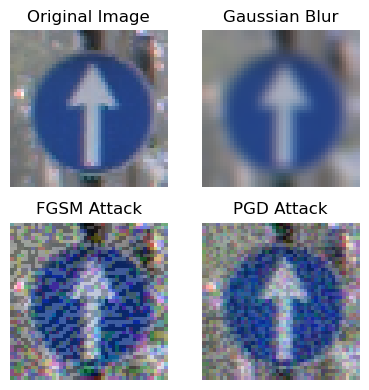

In [83]:
from PIL import Image
import matplotlib.pyplot as plt

def visualize_images_in_grid_with_titles(filenames, titles):
    """
    Loads and visualizes multiple PPM images in a 2x2 grid with titles.
    
    Args:
        filenames (list of str): The paths to the PPM image files.
        titles (list of str): Titles for each image corresponding to their folders.
    """
    fig, axs = plt.subplots(2, 2, figsize=(4, 4))  
    axs = axs.ravel()  
    
    for i, (filename, title) in enumerate(zip(filenames, titles)):
        image = Image.open(filename)
        axs[i].imshow(image)
        axs[i].set_title(title) 
        axs[i].axis('off')  

    plt.tight_layout()
    plt.show()

e
base_path = "/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/input/GTSRB_Final_Test_Images/GTSRB/Final_Test"  
image_name = "11776.ppm"  

folders = ["Images", "gaussian_blur", "fgsm_attack", "pgd_attack"]
titles = ["Original Image", "Gaussian Blur", "FGSM Attack", "PGD Attack"]  
file_paths = [f"{base_path}/{folder}/{image_name}" for folder in folders]

visualize_images_in_grid_with_titles(file_paths, titles)


In [89]:
!python cam.py gaussian_blur

Capturing images of type: gaussian_blur
[INFO]: Not loading pre-trained weights
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[INFO]: Freezing hidden layers...
/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/src/cam.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Image: 1
Image: 2
Image: 3
Image: 4
Image: 5
Image: 6
Image: 7
Im

In [90]:
!python cam.py pgd_attack


Capturing images of type: pgd_attack
[INFO]: Not loading pre-trained weights
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[INFO]: Freezing hidden layers...
/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/src/cam.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Image: 1
Image: 2
Image: 3
Image: 4
Image: 5
Image: 6
Image: 7
Image

In [91]:
!python cam.py fgsm_attack

Capturing images of type: fgsm_attack
[INFO]: Not loading pre-trained weights
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[INFO]: Freezing hidden layers...
/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/src/cam.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Image: 1
Image: 2
Image: 3
Image: 4
Image: 5
Image: 6
Image: 7
Imag

# Data Preparation

In [71]:
import os
import shutil

base_dir = '../input/GTSRB_Final_Test_Images/GTSRB/Final_Test'
gaussian_blur_dir = os.path.join(base_dir, 'gaussian_blur')
images_dir = os.path.join(base_dir, 'Images')
test_orig_dir = os.path.join(base_dir, 'original_subset')
os.makedirs(test_orig_dir, exist_ok=True)
gaussian_files = os.listdir(gaussian_blur_dir)
gaussian_filenames = [os.path.splitext(file)[0] for file in gaussian_files]
for filename in gaussian_filenames:
    src_path = os.path.join(images_dir, filename + '.ppm')
    dst_path = os.path.join(test_orig_dir, filename + '.ppm')
    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)
        print(f"Copied {src_path} to {dst_path}")
    else:
        print(f"File does not exist: {src_path}")


Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/06578.ppm to ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset/06578.ppm
Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/11004.ppm to ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset/11004.ppm
Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/01217.ppm to ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset/01217.ppm
Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/00109.ppm to ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset/00109.ppm
Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/09893.ppm to ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset/09893.ppm
Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07666.ppm to ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset/07666.ppm
Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/08555.ppm to ../in

In [92]:
!python cam.py original


Capturing images of type: original
[INFO]: Not loading pre-trained weights
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[INFO]: Freezing hidden layers...
/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/src/cam.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Image: 1
Image: 2
Image: 3
Image: 4
Image: 5
Image: 6
Image: 7
Image: 

# Convert .ppm to .jpg (Optional)

In [36]:
import cv2
import os
import glob

def convert_ppm_to_jpg(source_dir, target_dir):
    """
    Converts all PPM images in the specified directory to JPG format and saves them in a new directory.
    
    Args:
        source_dir (str): The directory containing PPM images.
        target_dir (str): The directory to save converted JPG images.
    """
    if not os.path.exists(source_dir):
        print(f"Source directory '{source_dir}' does not exist.")
        return

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        print(f"Created directory '{target_dir}'.")

    ppm_files = glob.glob(os.path.join(source_dir, '*.ppm'))
    if not ppm_files:
        print(f"No .ppm files found in '{source_dir}'.")
        return

    for ppm_path in ppm_files:
        try:

            image = cv2.imread(ppm_path)
            if image is None:
                print(f"Failed to read image from '{ppm_path}'.")
                continue

            base_name = os.path.basename(ppm_path)
            jpg_name = os.path.splitext(base_name)[0] + '.jpg'
            jpg_path = os.path.join(target_dir, jpg_name)
            

            cv2.imwrite(jpg_path, image)  
            print(f"Converted and saved {jpg_name}")
        except Exception as e:
            print(f"An error occurred processing {ppm_path}: {e}")


source_directory = '../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images'  
target_directory = '../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images_jpg'

convert_ppm_to_jpg(source_directory, target_directory)


Converted and saved 06578.jpg
Converted and saved 11004.jpg
Converted and saved 01217.jpg
Converted and saved 00109.jpg
Converted and saved 09893.jpg
Converted and saved 07666.jpg
Converted and saved 08555.jpg
Converted and saved 03400.jpg
Converted and saved 05071.jpg
Converted and saved 05717.jpg
Converted and saved 02078.jpg
Converted and saved 03366.jpg
Converted and saved 04409.jpg
Converted and saved 07100.jpg
Converted and saved 08233.jpg
Converted and saved 01571.jpg
Converted and saved 11762.jpg
Converted and saved 07114.jpg
Converted and saved 10468.jpg
Converted and saved 08227.jpg
Converted and saved 01565.jpg
Converted and saved 09139.jpg
Converted and saved 11776.jpg
Converted and saved 05703.jpg
Converted and saved 03372.jpg
Converted and saved 03414.jpg
Converted and saved 12519.jpg
Converted and saved 05065.jpg
Converted and saved 11010.jpg
Converted and saved 01203.jpg
Converted and saved 09887.jpg
Converted and saved 07672.jpg
Converted and saved 08541.jpg
Converted 

In [1]:
%cd outputs/test_results

/Users/gman/Desktop/Traffic_sign_clone_small/outputs/test_results


In [3]:
import os

list_operations = [
    "baseline_original_images",
    "baseline_gaussian_blur",
    "baseline_fgsm_attack",
    "baseline_pgd_attack",
    "de-gaussian_blur",
    "de-fgsm_attack",
    "de-pgd_attack",
    "de-fgsm_attack_light",
    "de-pgd_attack_light",
    "de-gaussian_blur_light"
]

base_directory = './'

for folder_name in list_operations:
    folder_path = os.path.join(base_directory, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Created folder: {folder_path}")


Created folder: ./baseline_original_images
Created folder: ./baseline_gaussian_blur
Created folder: ./baseline_fgsm_attack
Created folder: ./baseline_pgd_attack
Created folder: ./de-gaussian_blur
Created folder: ./de-fgsm_attack
Created folder: ./de-pgd_attack
Created folder: ./de-fgsm_attack_light
Created folder: ./de-pgd_attack_light
Created folder: ./de-gaussian_blur_light


In [ ]:
# baseline_original_images
# baseline_gaussian_blur
# baseline_fgsm_attack
# baseline_pgd_attack

# de-gaussian_blur
# de-fgsm_attack
# de-pgd_attack

# de-fgsm_attack_light
# de-pgd_attack_light
# de-gaussian_blur_light

In [18]:
%cd /Users/gman/Desktop/Traffic_sign_clone_small/src
!python cam.py de-gaussian_blur_light
%cd /Users/gman/Desktop/Traffic_sign_clone_small/input/GTSRB_Final_Test_Images/GTSRB/Final_Test

/Users/gman/Desktop/Traffic_sign_clone_small/src


# Visualize all the images

In [48]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

def display_images_grid(base_folder, folders,selected_files):
 
    num_folders = len(folders)
    num_images=6
    fig, axes = plt.subplots(nrows=num_images, ncols=num_folders, figsize=(12, 10))
    
    
    for row, file_name in enumerate(selected_files):
        for col, folder in enumerate(folders):
            file_path = os.path.join(base_folder, folder, file_name) 
            img = Image.open(file_path)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
            if row == 0:
                axes[row, col].set_title(folder)
    
    plt.tight_layout()
    plt.show()

base_folder = '/Users/gman/Desktop/Traffic_sign_clone_small/input/GTSRB_Final_Test_Images/GTSRB/Final_Test'
original_folder_path = os.path.join(base_folder, folders[0])
all_files = [f for f in os.listdir(original_folder_path) if f.endswith('ppm')]
selected_files = random.sample(all_files, 6)


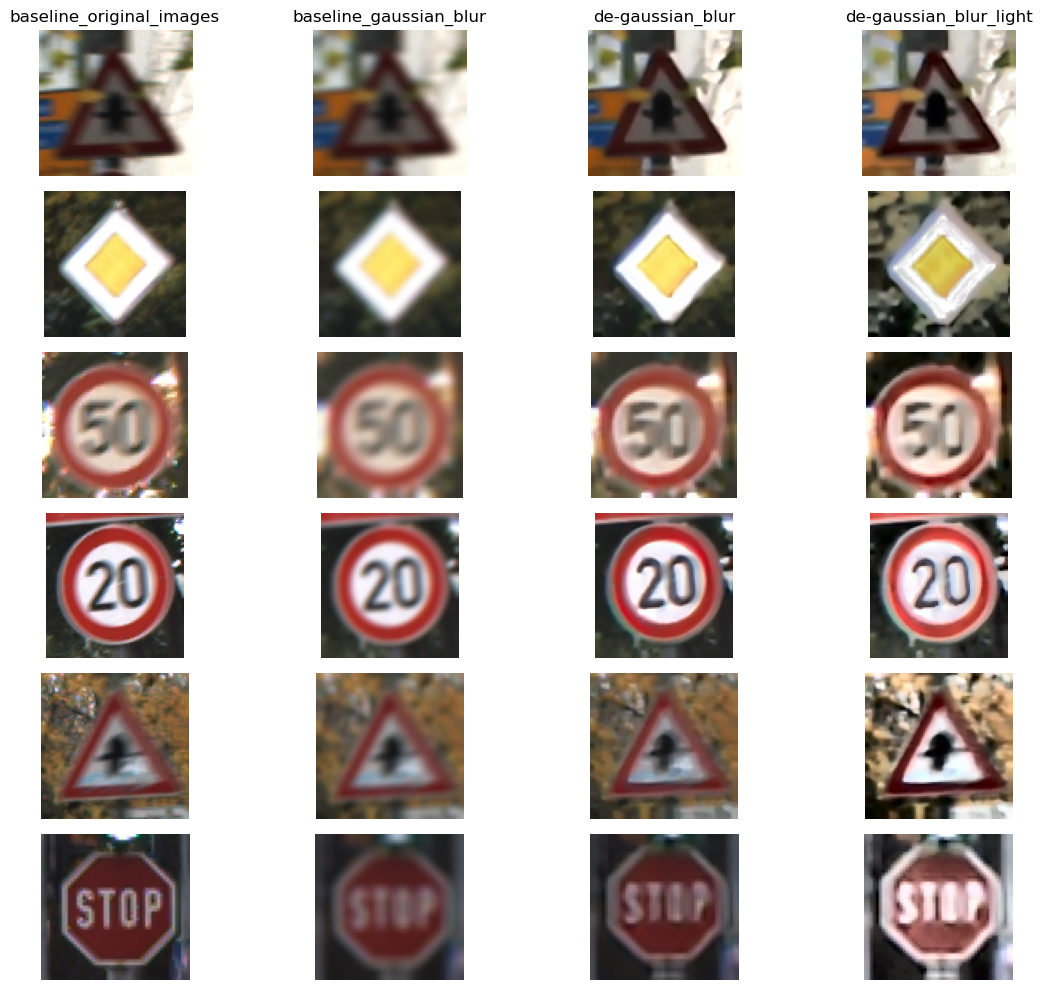

In [49]:

folders = [
    'baseline_original_images',
    'baseline_gaussian_blur',
    'de-gaussian_blur',
    'de-gaussian_blur_light'
]


display_images_grid(base_folder, folders, selected_files)

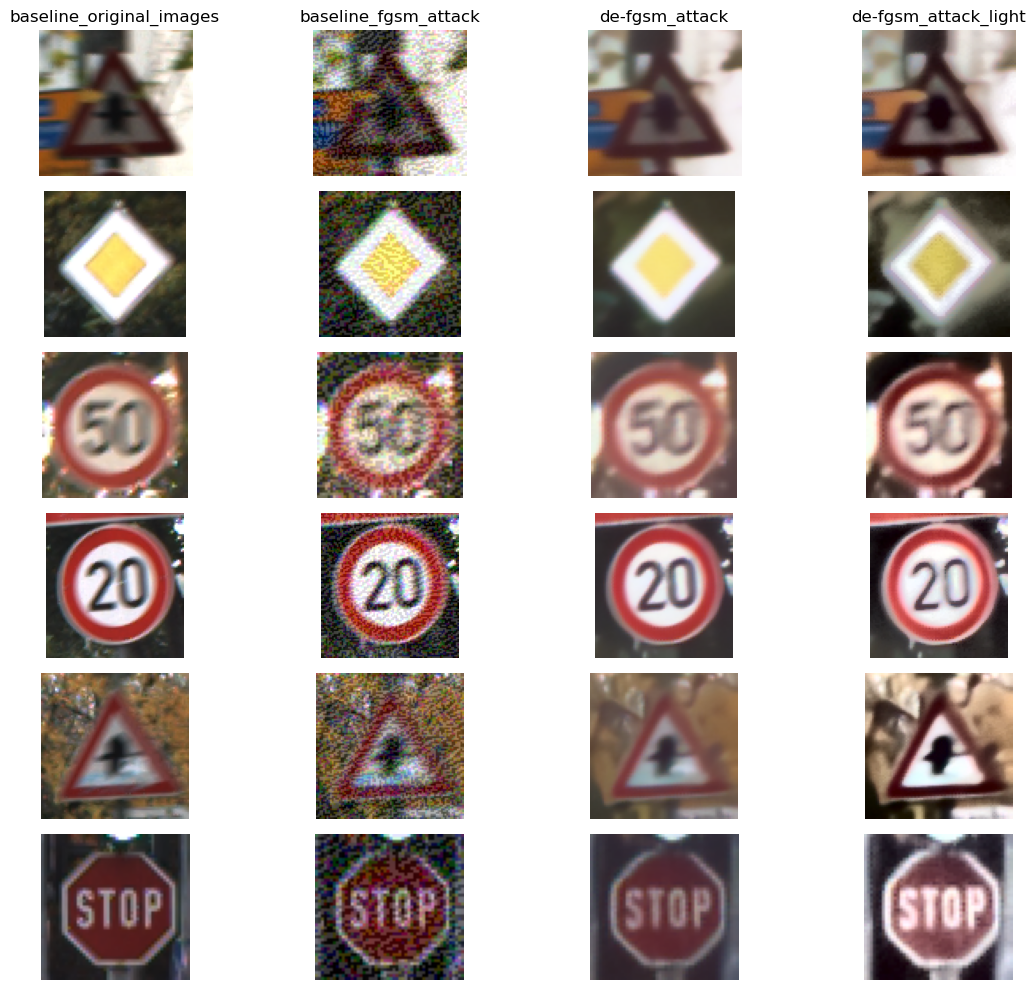

In [50]:

folders = [
    'baseline_original_images',
    'baseline_fgsm_attack',
    'de-fgsm_attack',
    'de-fgsm_attack_light'
]

display_images_grid(base_folder, folders, selected_files)


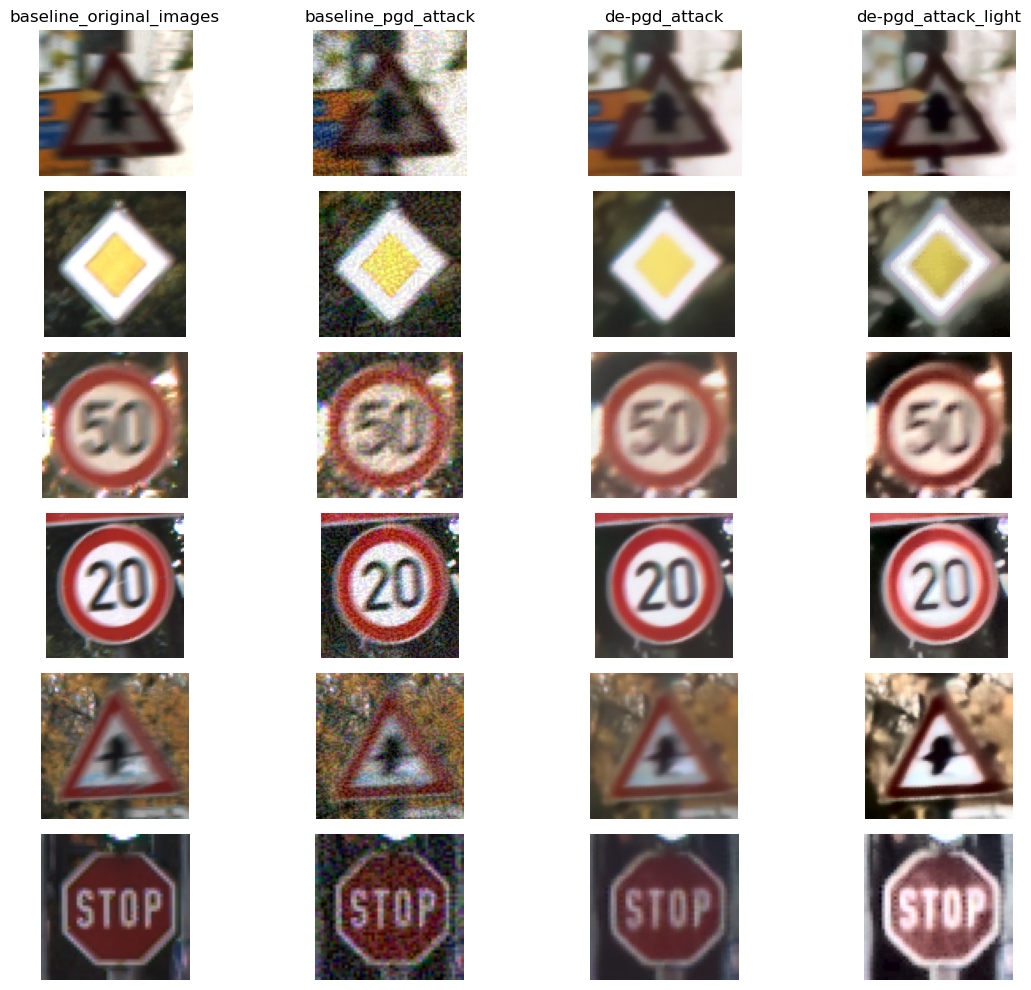

In [51]:

folders = [
    'baseline_original_images',
    'baseline_pgd_attack',
    'de-pgd_attack',
    'de-pgd_attack_light'
]

display_images_grid(base_folder, folders, selected_files)


# Visualize CAM

In [56]:
%cd /Users/gman/Desktop/Traffic_sign_clone_small/outputs/test_results

/Users/gman/Desktop/Traffic_sign_clone_small/outputs/test_results


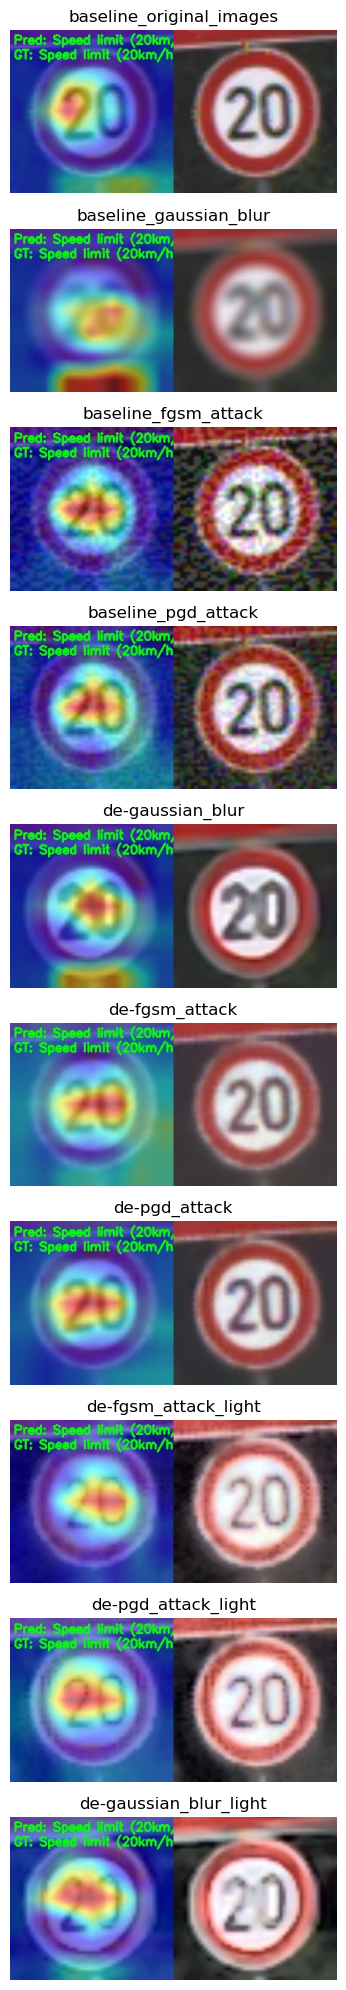

In [75]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def display_specific_image_vertically(base_folder, folders, image_name):
    num_folders = len(folders)
    fig, axes = plt.subplots(nrows=num_folders, ncols=1, figsize=(4, 20))  
    for i, folder in enumerate(folders):
        file_path = os.path.join(base_folder, folder, image_name)
        img = Image.open(file_path)
        if num_folders == 1: 
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(folder)
    plt.tight_layout()
    plt.show()

base_folder = './'
folders = [
    'baseline_original_images',
    'baseline_gaussian_blur',
    'baseline_fgsm_attack',
    'baseline_pgd_attack',
    'de-gaussian_blur',
    'de-fgsm_attack',
    'de-pgd_attack',
    'de-fgsm_attack_light',
    'de-pgd_attack_light',
    'de-gaussian_blur_light'
]
image_name = 'CAM_03009.jpg'
display_specific_image_vertically(base_folder, folders, image_name)